In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import re
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, HuberRegressor, RANSACRegressor, TheilSenRegressor, SGDRegressor
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

#plt.style.use('dark_background')

In [104]:
df = pd.read_csv('listings.csv')

In [105]:
# Since zip_code was from our query and not pulled from
# AirBnB itself, we'll need to drop it as it won't give us
# accurate insights or information.
df.drop('zip_code', axis = 1, inplace = True)

In [106]:
# Drop duplicates - after going through our data, it looks like the date does not have a strong correlation so we will drop those duplicates as well
df.drop_duplicates(['title', 'listing_type', 'city',
                   'numerical_descriptors', 'amenities'],
                   inplace = True)
df.reset_index(drop = True, inplace = True)

In [107]:
# orig_price = list(df[df['discounted'] == 1].index)
# df.loc[orig_price, 'price_per_night'] = df.loc[orig_price, 'original_value']

In [108]:
# Drop some columns that we determined as insignificant as well as some text based columns
df.drop(['title', 'num_reviews', 'rating', 'dates'], axis = 1, inplace = True)
df = df.reset_index(drop = True)

# Some simple cleaning and adjustments
df = df.rename({"city": "area"}, axis = 1)
df['discounted'] = df['discounted'].astype(int)

In [109]:
# Create dummies for area and listing_type - drop the first columns
areas = pd.get_dummies(df['area'], drop_first = True)
# dates = pd.get_dummies(df['dates'], drop_first = True)
listing_types = pd.get_dummies(df['listing_type'], drop_first = True)
df.drop(['area', 'listing_type'], axis = 1, inplace = True)

In [110]:
# Concatenate the 3 dfs
df = pd.concat([df, areas, listing_types], axis = 1)

In [111]:
# Convert the amenities into a list so we can use MLB
def str_to_list(amenities_str):
    if amenities_str == 'None':
        return []
    else:
        return amenities_str.strip().split(' - ')
    
df['amenities'] = df['amenities'].fillna('None')
df['amenities'] = df['amenities'].apply(str_to_list)

# Use MultiLabelBinarizer from scikit to encode
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(df['amenities']), columns = mlb.classes_)

# Concatenate the df with amenities and drop the amenities column
df.drop('amenities', axis = 1, inplace = True)
df = pd.concat([df, amenities_df], axis = 1)

In [112]:
def guest_num(nd_list):
    for nd_str in nd_list:
        if 'guest' in str.lower(nd_str):
            guest_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return guest_n
    return 0

def bedroom_num(nd_list):
    for nd_str in nd_list:
        if 'bedroom' in str.lower(nd_str):
            bedroom_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return bedroom_n
        elif 'studio' in str.lower(nd_str):
            nd_list.remove(nd_str)
            return 1
    return 0

def bed_num(nd_list):
    for nd_str in nd_list:
        if 'bed' in str.lower(nd_str):
            bed_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return bed_n
    return 0

def sharedbath_num(nd_list):
    for nd_str in nd_list:
        if 'shared bath' in str.lower(nd_str):
            sbath_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return sbath_n
    return 0

def bath_num(nd_list):
    for nd_str in nd_list:
        if 'half-bath' in str.lower(nd_str):
            nd_list.remove(nd_str)
            return .5
        if 'bath' in str.lower(nd_str):
            bath_n = float(nd_str.split()[0])
            nd_list.remove(nd_str)
            return bath_n
    return 0

In [113]:
df['numerical_descriptors'] = df['numerical_descriptors'].apply(str_to_list)

df['guests'] = df['numerical_descriptors'].apply(guest_num)
df['bedrooms'] = df['numerical_descriptors'].apply(bedroom_num)
df['beds'] = df['numerical_descriptors'].apply(bed_num)
df['shared baths'] = df['numerical_descriptors'].apply(sharedbath_num)
df['baths'] = df['numerical_descriptors'].apply(bath_num)


In [114]:
# guest_dummies = pd.get_dummies(df['guests'], drop_first = True)
# bedroom_dummies = pd.get_dummies(df['bedrooms'], drop_first = True)
# bed_dummies = pd.get_dummies(df['beds'], drop_first = True)
# sbath_dummies = pd.get_dummies(df['shared baths'], drop_first = True)
# bath_dummies = pd.get_dummies(df['baths'], drop_first = True)

# df = pd.concat([df, guest_dummies, bedroom_dummies, bed_dummies, sbath_dummies, bath_dummies], axis = 1)
df.drop('numerical_descriptors', axis = 1, inplace = True)

In [115]:
# If not discounted, fill in original_value with current price
df['original_value'] = df['original_value'].fillna(df['price_per_night'])

# If we look up how fees are calculated, we find out that the service fee is automatic.
# It is determined by AirBnB itself and has a formula:
# .14 * (n * p + c)
# where n is the number of nights
# p is the price per night
# c is the cleaning fee

# When putting up a listing or getting an idea of a listing, service fee does not come into play
# If I'm a host, I wouldn't know the service fee before putting my listing up
# If I'm a guest, I wouldn't use service fee as a parameter (neither would I use cleaning fee)

df.drop(['service_fee', 'cleaning_fee'], axis = 1, inplace = True)

df.drop(['original_value'], axis = 1, inplace = True)

In [62]:
# # Subtract the imputed fees from the price_per_night
# df_train.loc[msfee, 'price_per_night'] -= df_train.loc[msfee, 'service_fee']/2
# df_train.loc[mcfee, 'price_per_night'] -= df_train.loc[mcfee, 'cleaning_fee']/2

# df_test.loc[msfee_test, 'price_per_night'] -= df_test.loc[msfee_test, 'service_fee']/2
# df_test.loc[mcfee_test, 'price_per_night'] -= df_test.loc[mcfee_test, 'service_fee']/2

In [63]:
# erroneous_train = list(df_train[df_train['price_per_night'] < 0].index)
# erroneous_test = list(df_test[df_test['price_per_night'] < 0].index)
# # erroneous += list(df[df['rating'] > 5].index)
# df_train.drop(erroneous_train, inplace = True)
# df_test.drop(erroneous_test, inplace = True)

In [64]:
random_state = np.random.randint(1634)

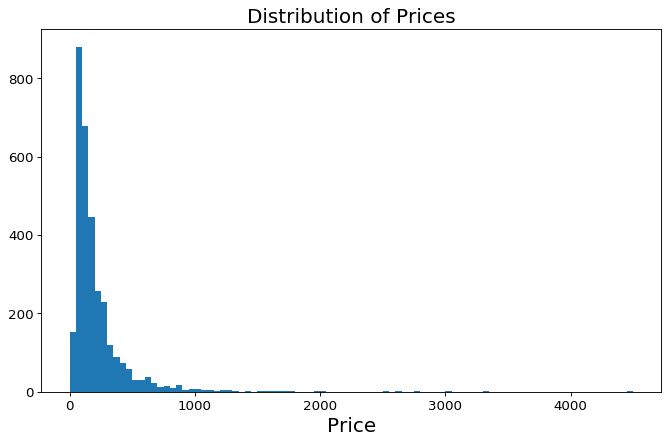

In [65]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.hist(df['price_per_night'], bins=np.linspace(0,4500, 91))
plt.title('Distribution of Prices', fontsize = 18)
plt.xlabel('Price', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('images/ydist.png')

In [66]:
df.to_csv('adjlistingsv2.csv', index = False)

***

***

***

In [116]:
X = df.drop('price_per_night', axis = 1)
y = df['price_per_night']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state)
model = LinearRegression()
model_fit = model.fit(X_train, y_train)
print("R2_train:", model_fit.score(X_train, y_train))
print("R2_test:", model_fit.score(X_test, y_test))

X_trainsm, X_testsm = X_train.copy(), X_test.copy()
X_trainsm['constant'] = 1
X_testsm['constant'] = 1
modelsm = sm.OLS(y_train, X_trainsm)
modelsm_fit = modelsm.fit()
modelsm_fit.summary()

R2_train: 0.6028527132016634
R2_test: -1.967522731742876e+19


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_night   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     18.03
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:58:06   Log-Likelihood:                -16804.
No. Observations:                2577   AIC:                         3.401e+04
Df Residuals:                    2376   BIC:                         3.519e+04
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
discounted                   -68.0615     12.205     -5.577      0.000     -91.995     -44.128
Albany                         5.9849     54.207      0.110      0.912    -100.314     112.284
Atchison Village              13.5022    174.912      0.077      0.938    -329.493     356.498
Atherton                     -35.2362     89.062     -0.396      0.692    -209.884     139.412
Balboa Terrace                83.1093     73.607      1.129      0.259     -61.232     227.451
Bayview                       -3.7351     41.979     -0.089      0.929     -86.053      78.583
Belding/Woods                 -7.2440    108.989     -0.066      0.947    -220.967     206.479
Belmont                        9.3459     47.079      0.199      0.843     -82.973     101.665
Belvedere Tiburon            387.5773    172.805      2.243      0.025      48.714     726.441
Berkeley                      28.3582     37.339      0.759      0.448     -44.861     101.578
Berkeley Hills                37.7980     49.276      0.767      0.443     -58.831     134.427
Bernal Heights                64.8979     38.715      1.676      0.094     -11.020     140.816
Brisbane                     303.0695     81.197      3.733      0.000     143.845     462.295
Burlingame                     6.4519     32.542      0.198      0.843     -57.361      70.265
Castro Valley                 16.5160    105.120      0.157      0.875    -189.621     222.653
Central Berkeley              20.4403     58.675      0.348      0.728     -94.620     135.500
Chinatown                    176.1067     39.981      4.405      0.000      97.705     254.508
Civic Center               -3.881e-13   7.61e-13     -0.510      0.610   -1.88e-12     1.1e-12
Clawson                       -7.3541     64.576     -0.114      0.909    -133.986     119.278
Clinton                       40.8465     70.065      0.583      0.560     -96.547     178.241
Cole Valley                  520.7117    127.105      4.097      0.000     271.463     769.961
Coronado                      -4.1397    173.020     -0.024      0.981    -343.426     335.146
Corte Madera                 261.2593     62.082      4.208      0.000     139.518     383.000
Cow Hollow                   227.2509     48.261      4.709      0.000     132.614     321.888
Crocker Amazon               -61.5913     41.330     -1.490      0.136    -142.639      19.456
Daly City                    -32.7028     25.368     -1.289      0.197     -82.449      17.044
Dogpatch                     125.4585    172.915      0.726      0.468    -213.621     464.538
Dogtown                      -21.2521     56.371     -0.377      0.706    -131.793      89.289
Downtown                     173.8810     31.934      5.445      0.000     111.261     236.501
Downtown Berkeley              5.5949     8

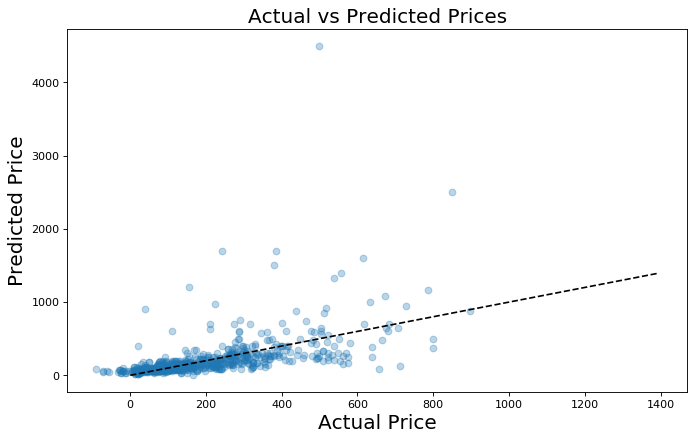

In [117]:
plt.figure(figsize = (10, 6), dpi = 80)
line = np.linspace(0,max(modelsm_fit.predict(X_testsm)) + 500,10001)
plt.scatter(modelsm_fit.predict(X_testsm), y_test, alpha = 0.3)
plt.plot(line, line, 'k--')
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/basepred.png')

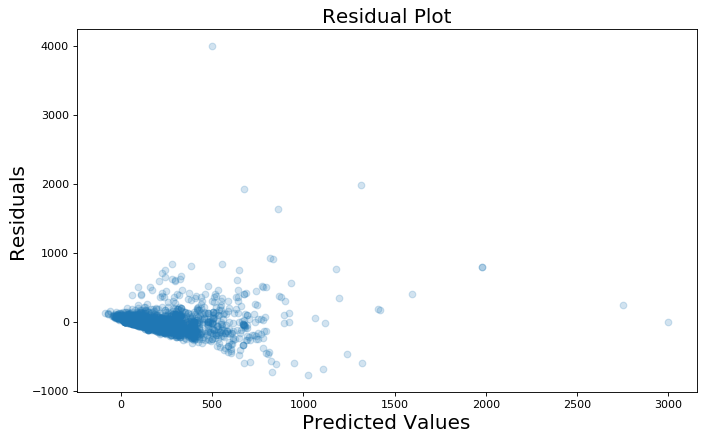

In [118]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.scatter(modelsm_fit.predict(X_trainsm), modelsm_fit.resid, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/baseres.png')

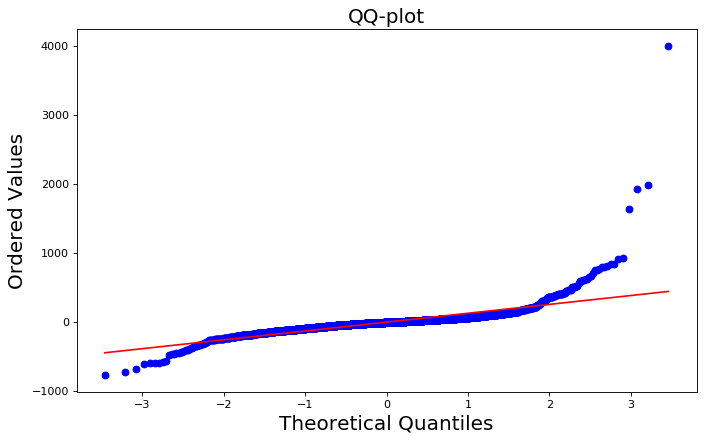

In [119]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(modelsm_fit.resid, dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/baseqq.png')

# Summary

* Errors are not normally distributed - try transformations later on
* Many features seem to have a high p-value so we may need to drop those

***

***

***

# Model 2

Let's try removing any features with a p-value of greater than 0.05

In [87]:
drop_cols = list(modelsm_fit.pvalues[modelsm_fit.pvalues > 0.05].index)

if 'constant' in drop_cols:
    drop_cols.remove('constant')
dfadj = df.drop(drop_cols, axis = 1)

In [95]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

dfadj2 = dfadj.copy()
while True:
    X = dfadj2.drop('price_per_night', axis = 1)
    y = dfadj2['price_per_night']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    model = LinearRegression()
    model_fit = model.fit(X_train, y_train)
    print("R2_train:", model_fit.score(X_train, y_train))
    print("R2_test:", model_fit.score(X_test, y_test))

    X_trainsm, X_testsm = X_train.copy(), X_test.copy()
    X_trainsm['constant'] = 1
    X_testsm['constant'] = 1
    modelsm = sm.OLS(y_train, X_trainsm)
    modelsm_fit = modelsm.fit()
    
    drop_cols = list(modelsm_fit.pvalues[modelsm_fit.pvalues > 0.05].index)
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    drop_cols += list(vif[vif['vif'] > 10]['variables'])
    if 'constant' in drop_cols:
        drop_cols.remove('constant')
    
    print(drop_cols)
    dfadj2 = dfadj2.drop(drop_cols, axis = 1)
    
    if len(drop_cols) == 0:
        break

R2_train: 0.503321726847193
R2_test: 0.5177025834187372
['Brisbane', 'Cole Valley', 'Elmhurst', 'Noe Valley', 'Shields Reid', 'camper/rv', 'entire apartment', 'entire guesthouse', 'hostel room', 'hut', 'room in serviced apartment', 'Kitchen', 'Gas fireplace', 'Massage table', 'bedrooms']
R2_train: 0.5021701834153754
R2_test: 0.3072903274603863
['Emeryville', 'Produce and Waterfront']
R2_train: 0.5210862171311156
R2_test: 0.1880682989228556
['Hillsborough', 'The Castro']
R2_train: 0.4605755694365965
R2_test: 0.36573041698743225
['Corte Madera', 'Muir Beach']
R2_train: 0.4302680984346443
R2_test: 0.4957187948497491
['Belvedere Tiburon', 'Tenderloin']
R2_train: 0.4253034824534754
R2_test: 0.5876638550554601
['North Beach', 'Pacific Heights']
R2_train: 0.4500551279488666
R2_test: 0.37387584088065307
[]


In [97]:
dfadj.shape

(3222, 47)

In [96]:
modelsm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_night   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     99.57
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          2.76e-312
Time:                        15:53:08   Log-Likelihood:                -17421.
No. Observations:                2577   AIC:                         3.489e+04
Df Residuals:                    2555   BIC:                         3.501e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
discounted              -53.2987     14.344     -3.716      0.000     -81.425     -25.173
Chinatown               143.0884     36.979      3.869      0.000      70.577     215.600
Cow Hollow              106.7316     37.412      2.853      0.004      33.371     180.092
Downtown                104.9489     25.608      4.098      0.000      54.735     155.163
Fisherman's Wharf       432.7443     42.313     10.227      0.000     349.773     515.716
Marina                  616.5854     53.399     11.547      0.000     511.876     721.295
Mill Valley             140.1808     32.910      4.260      0.000      75.648     204.714
Mission District         79.8386     33.127      2.410      0.016      14.880     144.797
Nob Hill                123.0948     33.194      3.708      0.000      58.004     188.185
Pacifica                141.9005     24.339      5.830      0.000      94.175     189.626
SoMa                    106.8043     43.126      2.477      0.013      22.238     191.371
Stinson Beach           309.5504     70.150      4.413      0.000     171.993     447.108
Twin Peaks              178.1499     63.450      2.808      0.005      53.731     302.569
Western Addition/NOPA   179.1731     28.968      6.185      0.000     122.371     235.975
entire vacation home    687.9086    210.244      3.272      0.001     275.643    1100.174
entire villa            745.4353     70.292     10.605      0.000     607.599     883.271
hostel beds            -199.2834     48.441     -4.114      0.000    -294.271    -104.296
private room            -37.0336     10.220     -3.624      0.000     -57.075     -16.993
shared room             -73.5054     27.584     -2.665      0.008    -127.596     -19.415
beds                     37.8280      3.341     11.323      0.000      31.277      44.379
baths                   103.9854      7.387     14.077      0.000      89.500     118.471
constant                 30.0925     10.495      2.867      0.004       9.513      50.673
==============================================================================
Omnibus:                     3650.872   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1764977.408
Skew:                           8.000   Prob(JB):                         0.00
Kurtosis:                     130.207   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

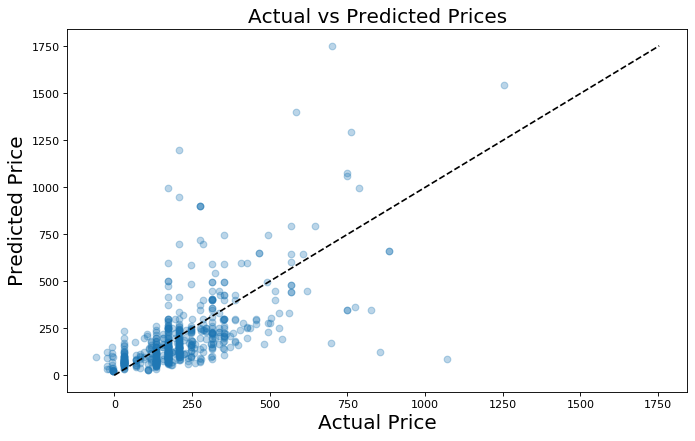

In [98]:
plt.figure(figsize = (10, 6), dpi = 80)
line = np.linspace(0,max(modelsm_fit.predict(X_testsm)) + 500,10001)
plt.scatter(modelsm_fit.predict(X_testsm), y_test, alpha = 0.3)
plt.plot(line, line, 'k--')
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/2pred.png')

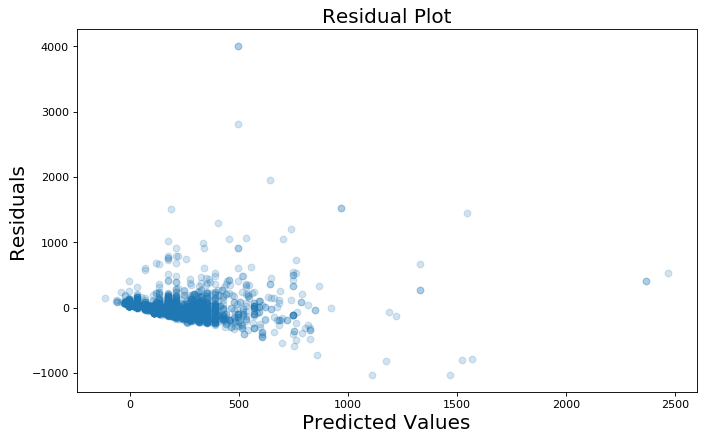

In [101]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.scatter(modelsm_fit.predict(X_trainsm), modelsm_fit.resid, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/2res.png')

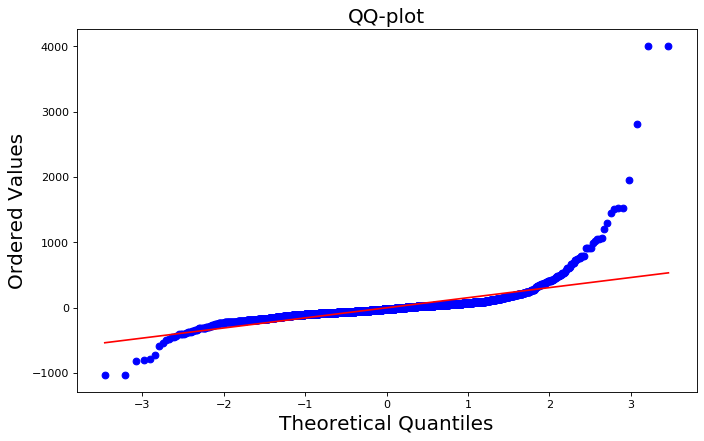

In [102]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(modelsm_fit.resid, dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/2qq.png')

In [29]:
df.to_csv('processed_listingsv2.csv', index = False)

***

***

***